In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to the network of protein-protein interactions in yeast.

In [1]:
%load_ext autoreload
%autoreload 1
%matplotlib inline

# utilities
import gc
import time
import os
import sys

os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
sys.path.append(os.getcwd())
%aimport fs_utils

sys.path.append(fs_utils.LIB_DIR)
sys.path.append(fs_utils.SCRIPTS_DIR)

In [2]:
import collections
import itertools
from importlib import reload
import pickle

# data analysis tools
import joblib
import random
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import *
import qgrid

tqdm.monitor_interval = 0

# network analysis tools
import igraph as ig

# multiprocessing tools
import subprocess
import multiprocessing as mp

# visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%aimport networks
%aimport qtls
%aimport util
%aimport ontologies

gc.enable()

%autosave 15

INTERACTOME_RANDITER = 1024

/home/vvi/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/vvi/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Autosaving every 15 seconds


## Datasets used

Take a look at readme.md in /data folder for data description. (currently unavailable)

In [4]:
random.seed(int(time.time()))

# 112 segregants genotyped by inherited marker variants
''' Where possible, gene names were converted from systematic to standard notation '''

expression_df, genotypes_df, qtls_df = {}, {}, {}

expression_df["eQTLs_2011"] = pd.read_table("./data/eQTLs/2011/expression.csv")
# expression_df["eQTLs_2018"] = pd.read_table("./data/eQTLs/2018/expression.csv")
expression_df["pQTLs_2011"] = pd.read_table("./data/pQTLs/2011/expression.csv")

genotypes_df["eQTLs_2011"] = pd.read_table("./data/eQTLs/2011/genotypes.csv")
# genotypes_df["eQTLs_2011_interpolated"] = pd.read_table(
#     "./data/eQTLs/2011/genotypes_interpolated.csv")
# genotypes_df["eQTLs_2018_full"] = pd.read_table(
#     "./data/eQTLs/2018/genotypes_full.csv")
# genotypes_df["eQTLs_2018_filtered"] = pd.read_table(
#     "./data/eQTLs/2018/genotypes_filtered.csv")
genotypes_df["pQTLs_2011"] = pd.read_table("./data/pQTLs/2011/genotypes.csv")

qtls_df["eQTLs_2011_MatrixEQTL"] = pd.read_table(
    "./data/eQTLs/2011/qtls_MatrixEQTL.csv")#.query("q_value <= 0.001")
qtls_df["eQTLs_2011_albert&bloom"] = pd.read_table(
    "./data/eQTLs/2011/qtls_albert&bloom_script_output.csv")
qtls_df["eQTLs_2011_albert&bloom_interpolated"] = pd.read_table(
"./data/eQTLs/2011/qtls_albert&bloom_interpolated.csv")
qtls_df["eQTLs_2018_albert&bloom"] = pd.read_table(
    "./data/eQTLs/2018/qtls_albert&bloom_from_paper.csv")
# qtls_df["eQTLs_2018_MatrixEQTL"] = pd.read_table(
# "./data/eQTLs/2018/qtls_MatrixEQTL_with_covariates_ANOVA.csv")
qtls_df["pQTLs_2011_MatrixEQTL"] = pd.read_table(
    "./data/pQTLs/2011/qtls_MatrixEQTL.csv").query("q_value <= 0.001")
qtls_df["pQTLs_2011_albert&bloom"] = pd.read_table(
    "./data/pQTLs/2011/qtls_albert&bloom_script_output.csv")

# # Physical and genetic interactions taken from TheBioGrid project
# full_interactome_df = pd.read_table(
#     "./data/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[
#     full_interactome_df['Publication year'] <= 2011]

# genetic_interaction_categories = [
#     "additive genetic interaction defined by inequality",
#     "suppressive genetic interaction defined by inequality",
#     "synthetic genetic interaction defined by inequality"
# ]
# physical_interaction_categories = [
#     "association", "colocalization", "direct interaction",
#     "physical association"
# ]

# interaction_categories = genetic_interaction_categories + physical_interaction_categories
# interactome_df = full_interactome_df.copy()
# interactome_df.set_index('Interaction Type', inplace=True)
# genetic_interactions_df = interactome_df[interactome_df.index.isin(
#     genetic_interaction_categories)]
# physical_interactions_df = interactome_df[interactome_df.index.isin(
#     physical_interaction_categories)]


# def extract_interactions(interactions_df):
#     ''' Helper function to retrieve the edges of the graph of interactions '''
#     return interactions_df[["Interactor A", "Interactor B"]].values


# interactome_graphs_dict = {}
# for category_name in interaction_categories + ["all", "genetic", "physical"]:
#     with open(
#             "./data/interactions/{}_interactions_graph.pkl".format(
#                 category_name), "rb") as pickle_file:
#         interactome_graphs_dict[category_name] = pickle.load(pickle_file)
# interactome_graph = interactome_graphs_dict["physical"]

## Introduction and problem formulation

It seems rational to suppose that transcription and translation levels must be controlled by similar genetic mechanisms.  
Unfortunately, at the first sight there is no evidence to support that intuition: sets of eQTLs and pQTLs linked to given gene show no significant overlap for almost all genes. This is illustrated by the histogram below.

In [ ]:
%%time

reload(qtls)
gene_pool = np.intersect1d(expression_df["eQTLs_2011"]["gene"],
                           expression_df["pQTLs_2011"]["gene"])

linkage_overlap_data = []
for gene_name in gene_pool:
    linked_eQTLs = qtls.linked_markers(qtls_df["eQTLs_2011_albert&bloom"],
                                       [gene_name])
    linked_pQTLs = qtls.linked_markers(qtls_df["pQTLs_2011_albert&bloom"],
                                       [gene_name])
    linkage_overlap_data.append(
        qtls.jaccard(set(linked_eQTLs), set(linked_pQTLs)))

sns.set()
qtls.qtl_overlap_hist(linkage_overlap_data, "eQTLs_pQTLs_old")

In [ ]:
""" Using simple PPIN-based test to assess whether interacting genes really have better eQTL/pQTL intersection 
    TODO: вычислять доверительные интервалы
"""

print(qtls_df["eQTLs_2011_albert&bloom"].shape, qtls_df["pQTLs_2011_albert&bloom"].shape)

def eQTL_pQTL_similarity_ppin_test(qtl_type2graph, interactome_graph):
    scores = []
    for marker in np.intersect1d(
            qtl_type2graph["eQTLs"].vs.select(part=0)["name"],
            qtl_type2graph["pQTLs"].vs.select(part=0)["name"]):
        linked = {}
        for qtl_type in ["eQTLs", "pQTLs"]:
            linked[qtl_type] = set(qtl_type2graph[qtl_type].vs[qtl_type2graph[
                qtl_type].neighborhood(marker, mode="out")]["name"])
            linked[qtl_type].remove(marker)
        matches = len(linked["eQTLs"] & linked["pQTLs"])
        tests_count = len(linked["eQTLs"]) * len(linked["pQTLs"])
        for qtl_type in ["eQTLs", "pQTLs"]:
            linked[qtl_type] &= set(interactome_graph.vs["name"])
        for eQTL_gene in linked["eQTLs"]:
            for pQTL_gene in linked["pQTLs"]:
                if eQTL_gene != pQTL_gene \
                        and interactome_graph.are_connected(eQTL_gene, pQTL_gene):
                    matches += 1
        scores.append(matches / tests_count)
    return np.mean(scores)


tuples_for_df = []
for LOD_cutoff in tqdm_notebook(np.arange(0, 6)):  #10. ** np.arange(-5, -1):
    qtl_graph = {"eQTLs" : networks.graph_from_edges(qtls_df["eQTLs_2011_albert&bloom"]\
                                                     .query("LOD >= {}".format(LOD_cutoff))\ #.query("q_value <= {}".format(q_cutoff))
                                                     [["SNP", "gene"]].values, directed=True),
                 "pQTLs" : networks.graph_from_edges(qtls_df["pQTLs_2011_albert&bloom"]\
                                                     .query("LOD >= {}".format(LOD_cutoff))\ #.query("q_value <= {}".format(q_cutoff))
                                                     [["SNP", "gene"]].values, directed=True)}

    real_test_results = eQTL_pQTL_similarity_ppin_test(qtl_graph,
                                                       interactome_graph)
    randomized_test_results = []
    for i in range(INTERACTOME_RANDITER):
        with open(
                "./data/randomized_interactome_copies/physical/{}.pkl".format(
                    i), "rb") as pickle_file:
            randomized_interactome_graph = pickle.load(pickle_file)
            randomized_test_results.append(
                eQTL_pQTL_similarity_ppin_test(qtl_graph,
                                               randomized_interactome_graph))
    tuples_for_df.append((LOD_cutoff, real_test_results,
                          np.mean(randomized_test_results),
                          *util.confidence_interval(randomized_test_results)))

results_df = pd.DataFrame(
    tuples_for_df, columns=["LOD_cutoff", "real_mean", "random_mean", "CI_l", "CI_r"])
results_df.to_csv(
    "./data/interactions/eQTL_pQTL_intersection_albert&bloom.csv",
    sep='\t',
    index=False)
display(results_df)

In [ ]:
""" marker-to-module test: simple test aimed to demonstrate that eQTL/pQTL intersection ratio is higher
                            if we link markers not to genes but to functional modules they belong to
"""

gene_pool = np.intersect1d(expression_df["eQTLs_2011"]["gene"].values,
                           expression_df["pQTLs_2011"]["gene"].values)

for LOD_cutoff in tqdm_notebook(np.arange(3, 8)):  #10. ** np.arange(-5, -1):
    print("LOD-score threshold: {}".format(LOD_cutoff))
    result_rows = []
    for modules_type in [
            "thecellmap", "kegg_modules", "kegg_pathways", "geneontology"
    ]:
        qtl_graph = {"eQTLs" : networks.graph_from_edges(qtls_df["eQTLs_2011_albert&bloom"]\
                                                         .query("LOD >= {}".format(LOD_cutoff))\ #.query("q_value <= {}".format(q_cutoff))
                                                         [["SNP", "gene"]].values, directed=True),
                     "pQTLs" : networks.graph_from_edges(qtls_df["pQTLs_2011_albert&bloom"]\
                                                         .query("LOD >= {}".format(LOD_cutoff))\ #.query("q_value <= {}".format(q_cutoff))
                                                         [["SNP", "gene"]].values, directed=True)}

        with open("./results/{}/modules_dict.pkl".format(modules_type),
                  "rb") as pickle_file:
            modules_dict = pickle.load(pickle_file)

        module_genes_union = np.intersect1d(
            np.unique(np.hstack(modules_dict.values())), gene_pool)
        module_qtls = {}
        for qtl_type in ["eQTLs", "pQTLs"]:
            genes_with_linkages = np.intersect1d(
                module_genes_union,
                qtl_graph[qtl_type].vs.select(part=1)["name"])
            induced_subgraph = qtl_graph[qtl_type].subgraph(
                np.unique(
                    np.hstack(qtl_graph[qtl_type].neighborhood(
                        genes_with_linkages))))
            module_qtls[qtl_type] = [
                (marker, modules_type)
                for marker in induced_subgraph.vs.select(part=0)["name"]
            ]

        randomized_J_scores = []
        for i in range(INTERACTOME_RANDITER):
            randomized_modules = [
                np.random.RandomState().choice(gene_pool, len(module_genes))
                for module_genes in modules_dict.values()
            ]
            randomized_module_genes_union = np.unique(
                np.hstack(randomized_modules))
            randomized_module_qtls = {}
            for qtl_type in ["eQTLs", "pQTLs"]:
                genes_with_linkages = np.intersect1d(
                    randomized_module_genes_union,
                    qtl_graph[qtl_type].vs.select(part=1)["name"])
                induced_subgraph = qtl_graph[qtl_type].subgraph(
                    np.unique(
                        np.hstack(qtl_graph[qtl_type].neighborhood(
                            genes_with_linkages))))
                randomized_module_qtls[qtl_type] = [
                    (marker, modules_type)
                    for marker in induced_subgraph.vs.select(part=0)["name"]
                ]
            randomized_J_scores.append(
                qtls.jaccard(
                    set(randomized_module_qtls["eQTLs"]),
                    set(randomized_module_qtls["pQTLs"])))
        result_rows.append((
            modules_type,
            qtls.jaccard(set(module_qtls["eQTLs"]), set(module_qtls["pQTLs"])),
            np.mean(randomized_J_scores),
            *util.confidence_interval(randomized_J_scores)))
    display(
        pd.DataFrame(
            result_rows,
            columns=[
                "modules_type", "jaccard", "avg_rand_jaccard",
                "rand_CI.l", "rand_CI.r"
            ]))

Hypothesis arises: maybe not single genes, but functional modules tend to share linkages.  
The goal of this work is to test that hypothesis using yeast interactome data.

## Predicting pQTLs from eQTLs using PPI networks

Now, when approach using interaction networks is justified, it's time to provide solid ground: if significant fraction of pQTLs can be rediscovered from eQTLs linked to genes interacting with given (including itself), it will serve as an additional evidence for hypothesis being actually true (once again, no sophisticated clustering was performed here, while it would possibly yield better results).  

The main idea is not to test all (marker, gene) pairs but to filter for trusted only. In order to get rid of the pairs that will not link (or at least to dump more false than real linkages), the following approach is proposed: 
1. For each gene with measured protein abundance select its eQTL linkages as candidates into pQTLs. 
2. Extend eQTL linkages with those of the interacting genes. 

FDR decreases for the same q-value threshold, which results in more trustworthy observations.

Here is some statistics computed from some subgraphs of the interactome. 

**Physical interactions only**:   
- Common linkages: 2021, 32.7977929243752%
- Old linkages, total: 6162
- New linkages, total: 4048
- New linkages found: 2027

**Full interactome**:
- Common linkages: 3688, 59.85069782538137%
- Old linkages, total: 6162
- New linkages, total: 6219
- New linkages found: 2531

It becomes evident, that a significant fraction of estimated pQTLs can be reproduced using this approach.  
**Nevertheless, many questions arise**:
- Which fraction of trans-pQTLs is reproduced? (and is this approach capable of detecting those)
- Are all the hotspots reproduced? If some are not, why then? It is worth mentioning, that some of those were given cryptic names which are nowhere to be found. 
- How robust the results are? So far results are not compared with those computed from simulated, perturbed graphs. 

In [ ]:
modules_type = "thecellmap"
with open("./results/{}/modules_dict.pkl".format(modules_type), "rb") as pickle_file:
    modules_dict = pickle.load(pickle_file)
fdr_cutoffs = np.logspace(-5, -2, 10)

In [ ]:
"""Basic information about the functional modules: numbers of vertices and edges for pseudo- and simple subgraphs spanned by modules' genes"""
%%time

for simplify_flag in [False, True]:
    modules_stats = networks.basic_module_info(
         interactome_graph=interactome_graph, 
         modules_dict=modules_dict, 
         modules_type=modules_type,
         simplify=simplify_flag)
    modules_stats.to_csv("./results/{}/".format(modules_type) 
              + ("simplified" if simplify_flag else "raw") 
              + "_module_stats.csv", sep='\t', index=False)
    display(modules_stats.sort_values(by="genes_count", ascending=False))

In [ ]:
gene_pool = np.intersect1d(expression_df["eQTLs_interpolated"]["gene"], expression_df["pQTLs"]["gene"])

In [ ]:

%%time
reload(qtls)

def calculate_eqtl_pqtl_intersection(modules_type):
    with open("./results/{}/modules_dict.pkl".format(modules_type), "rb") as pickle_file:
        modules_dict = pickle.load(pickle_file)
    for eqtls_type in ["old"]:
        print("{}: {}".format(modules_type, eqtls_type))
        pd.DataFrame(
            [
                (q_cutoff, *qtls.qtl_overlap_test(qtls_df["eQTLs_{}".format(eqtls_type)].query("q_value < {}".format(q_cutoff)),
                                                  qtls_df["pQTLs"].query("q_value < {}".format(q_cutoff)),
                                                  gene_pool, modules_dict))
                for q_cutoff in 10.**np.arange(-8, -1)
            ],
            columns = ["q_value_cutoff", "real_modules", "random_modules"],
            dtype=np.float32
        ).to_csv("./results/{}/eQTL_pQTL_intersection_{}.csv".format(modules_type, eqtls_type), sep='\t', index=False)
        
module_types = ["geneontology"]        
joblib.Parallel(n_jobs=len(modules_type))(
    joblib.delayed(calculate_eqtl_pqtl_intersection)(modules_type) 
    for modules_type in module_types
)

In [ ]:
""" The same information, only visualized. """

%%time

intersection_j, randomized_intersection_j = qtls.qtl_overlap_by_module_test(qtls_df["eQTLs_old"], qtls_df["pQTLs"], 
                                                                            gene_pool, modules_dict)

qtls.qtl_overlap_hist(intersection_j, modules_type)
qtls.qtl_overlap_hist(randomized_intersection_j, modules_type + "_randomized")

In [ ]:
"""
OBSERVATION: gene pool tends to be biased towards high eQTL/pQTL overlap ration.
Reasons and interpretations of such behaviour remain unclear.    
"""

sample_size = 10
def randomize_and_overlap(sample_size, iter_num=200):
    jaccard_coeffs = []
    for i in range(iter_num):
        gene_sample = np.random.RandomState().choice(gene_pool, sample_size, replace=False)
        linked_eQTLs = set(qtls.linked_markers(qtls_df["eQTLs_old"], gene_sample))
        linked_pQTLs = set(qtls.linked_markers(qtls_df["pQTLs"], gene_sample))
        jaccard_coeffs.append(qtls.jaccard(linked_eQTLs, linked_pQTLs))
    return np.mean(jaccard_coeffs)

display(
    pd.DataFrame(
        [
            (q_cutoff, randomize_and_overlap(sample_size))
            for q_cutoff in 10.**np.arange(-8, -1)
        ],
        columns = ["q_value_cutoff", "random_samples_of_size_{}".format(sample_size)],
        dtype=np.float32
    )
)

In [ ]:
""" Helper cell. Used to visualize results of full-graph test and PPIN test. """

%%time
reload(qtls)
for expression_df, qtl_df, qtl_type in [(expression_df["eQTLs_old"], qtls_df["eQTLs_old"], "eQTLs"),
                                        (expression_df["pQTLs"], qtls_df["pQTLs"], "pQTLs")]:
    qtls.plot_analysis_results(
        expression_df=expression_df,
        interactions_type="physical",
        interactome_graph=interactome_graph,
        modules_dict=modules_dict,
        modules_type=modules_type,
        qtl_df=qtl_df,
        qtl_type=qtl_type
    )
    


In [ ]:
""" INVESTIGATION: how precisely can pQTLs be predicted from eQTLs given PPIN? """

%%time

reload(qtls)
print(modules_type)

predictions_dict = {}
for module_name, module_genes in tqdm(modules_dict.items()):
    predictions_dict[module_name] = qtls.PqtlPredictor(
        eqtls_df=qtls_df["eQTLs_old"], pqtls_df=qtls_df["pQTLs"],
        pqtls_expression_df=expression_df["pQTLs"], pqtls_genotypes_df=genotypes_df["pQTLs"],
        module_name=module_name, module_genes=module_genes,
        interactome_graph=interactome_graph
    ).predict()

display(pd.DataFrame(
    ((key, *values) for key, values in predictions_dict.items()),
    columns=["module_name", "common_pQTLs", "overlap_ratio", "old_pQTLs", "predicted_pQTLs", "delta"]
).sort_values(by="overlap_ratio", ascending=False))

## Analyzing new data: eQTLs

In [ ]:
""" How many eQTLs are in both real and interpolated data? 
    TODO: Collect more information: jaccard coefficient, percentage of reproduced values etc
"""

len(np.intersect1d(
    list(map(tuple, qtls_df["eQTLs_interpolated"][["SNP", "gene"]].values)), 
    list(map(tuple, qtls_df["eQTLs_old"][["SNP", "gene"]].values))
))

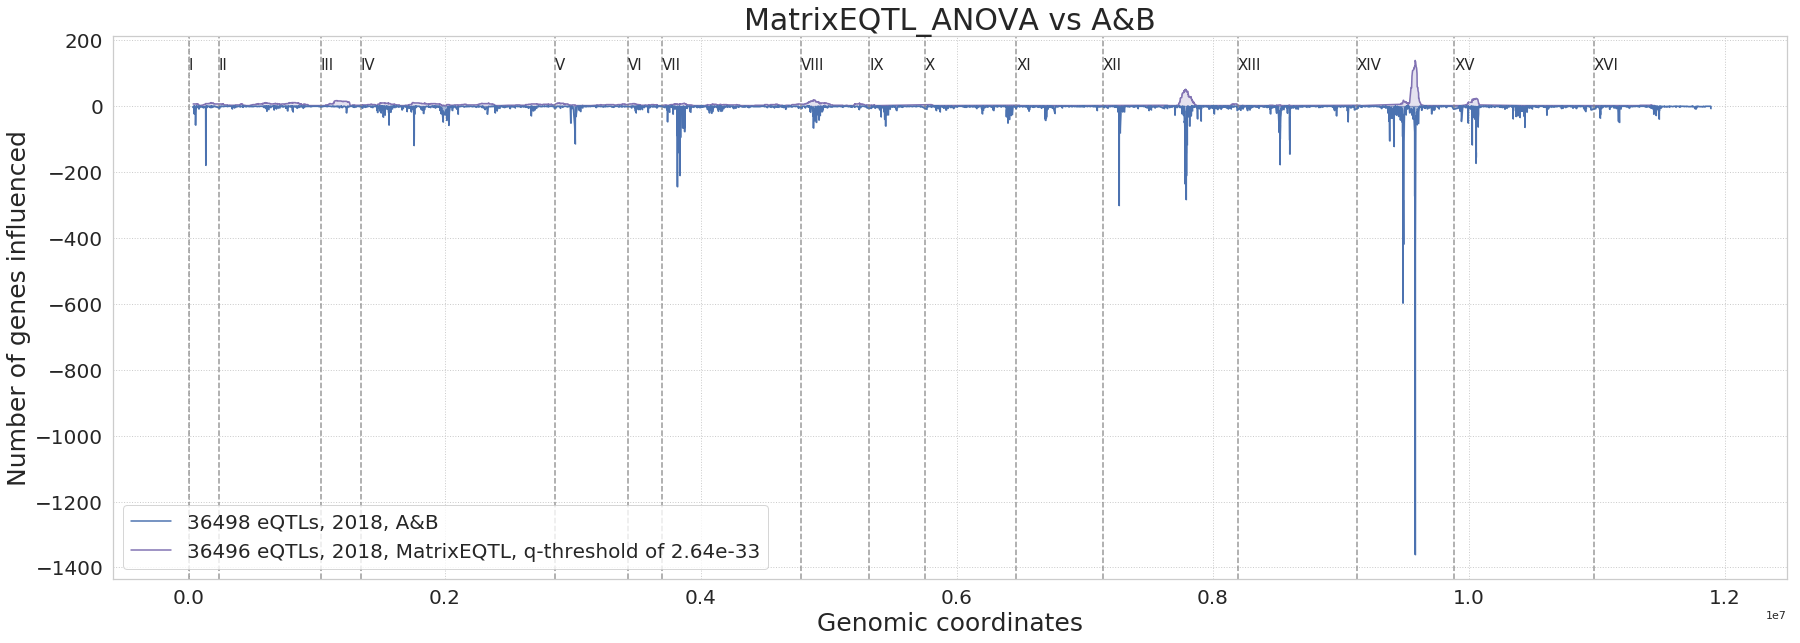

In [46]:
""" Plot the distributions of each QTL dataset"""

sns.set(style="whitegrid")


q_value_threshold = 1e-3
with open("./data/genomic_features/order_of_markers.pkl", "rb") as pickle_file:
    marker2location = pickle.load(pickle_file)
with open("./data/genomic_features/chromosome_endpoints.pkl",
          "rb") as pickle_file:
    chromosome_endpoints = pickle.load(pickle_file)

old_eQTL_markers, old_eQTL_y = qtls.linkages2gencoords(QTLs_2011_reference)
    #qtls_df["eQTLs_2011_MatrixEQTL"])
# interpolated_eQTL_markers, interpolated_eQTL_y = qtls.linkages2gencoords(
#     qtls_df["eQTLs_2011_albert&bloom_interpolated"])
# interpolated_eQTL_markers, interpolated_eQTL_y = qtls.linkages2gencoords(pd.DataFrame(np.vstack(qtl_list), columns=["SNP", "gene"]))
# new_eQTL_markers, new_eQTL_y = qtls.linkages2gencoords(qtls_df["eQTLs_2011_albert&bloom"])
# pQTL_markers, pQTL_y = qtls.linkages2gencoords(
#     qtls_df["pQTLs_2011_albert&bloom"])
# pQTL_y = pQTL_y / expression_df["pQTLs_2011"].shape[0]
# recomputed_new_eQTL_markers, recomputed_new_eQTL_y = qtls.linkages2gencoords(qtls_df["recomputed_new_eQTLs"][qtls_df["recomputed_new_eQTLs"]["q.value"] <= 1e-32])
# recomputed_new_eQTL_markers, recomputed_new_eQTL_y = qtls.linkages2gencoords(pd.DataFrame(np.vstack(qtl_list), columns=["SNP", "gene"]))
# recomputed_qtls_df = pd.read_table("./email_to_albert&bloom/pQTLs_albert&bloom.csv")[["pmarker", "gene"]]
# recomputed_qtls_df["pmarker"] = recomputed_qtls_df["pmarker"].apply(lambda s: s.split(":")[1])
# recomputed_qtls_df.rename(columns={"pmarker":"SNP"}, inplace=True)
# recomputed_qtls_df.drop_duplicates(inplace=True)
# recomputed_qtls_df["gene"] = recomputed_qtls_df["gene"].apply(networks.convert_to_std)
recomputed_QTL_markers, recomputed_QTL_y = qtls.linkages2gencoords(QTLs_2011_experimental)
    #pd.read_table("./data/eQTLs/2011/qtls_naive.csv").query("q_value <= 0.01"))

old_eQTL_x = list(map(marker2location.get, old_eQTL_markers))
# interpolated_eQTL_x = list(map(marker2location.get, interpolated_eQTL_markers))
# new_eQTL_x = list(map(marker2location.get, new_eQTL_markers))
# pQTL_x = list(map(marker2location.get, pQTL_markers))
recomputed_QTL_x = list(
    map(marker2location.get, recomputed_QTL_markers))

colors_dict = dict(
    zip([
        "eQTLs_2011", "eQTLs_2011_interpolated", "eQTLs_2018", "pQTLs_2011",
        "recomputed"
    ], plt.rcParams['axes.prop_cycle'].by_key()['color'][:5]))

plt.figure(figsize=(30, 10))
plt.title(
    "MatrixEQTL_ANOVA vs A&B",
    fontsize=30)
for n in range(1, 17):
    plt.axvline(
        x=chromosome_endpoints[n - 1], linestyle='--', color='grey', alpha=0.8)
    plt.text(
        chromosome_endpoints[n - 1],
        0.8 * np.max(recomputed_QTL_y),
        util.as_roman(n),
        fontsize=15)

plt.plot(
    old_eQTL_x,
    -old_eQTL_y,
    label="{} eQTLs, 2018, A&B".format(QTLs_2011_reference.shape[0]),
    color=colors_dict["eQTLs_2011"])
plt.fill_between(
    old_eQTL_x, -old_eQTL_y, 0, alpha=0.5, color=colors_dict["eQTLs_2011"])

# chunks = np.linspace(0, chromosome_endpoints[16], 100)
# vals = np.zeros(len(chunks))
# for i in range(len(chunks) - 1):
#     vals[i] = sum((chunks[i] < val < chunks[i + 1] for val in interpolated_eQTL_x))
# plt.step(chunks, -vals, label="markers in chunk", color=plt.rcParams["axes.prop_cycle"].by_key()["color"][0])

# plt.plot(
#     interpolated_eQTL_x,
#     interpolated_eQTL_y,
#     label="eQTLs, interpolated: old markers, new expression",
#     alpha=0.7,
#     color=colors_dict["eQTLs_2011_interpolated"])
# plt.fill_between(
#     interpolated_eQTL_x,
#     0,
#     interpolated_eQTL_y,
#     alpha=0.5,
#     color=colors_dict["eQTLs_2011_interpolated"])

# plt.plot(
#     new_eQTL_x,
#     -new_eQTL_y,
#     label="36498 eQTLs, A&B (from paper)",
#     alpha=1,
#     color=colors_dict["eQTLs_2018"],
#     zorder=1)
# plt.fill_between(
#     new_eQTL_x, -new_eQTL_y, 0, alpha=0.7, color=colors_dict["eQTLs_2018"])

# plt.plot(
#     pQTL_x,
#     -pQTL_y,
#     label="pQTLs, 2011, algorithm of Albert&Bloom",
#     alpha=0.7,
#     color=colors_dict["pQTLs_2011"])
# plt.fill_between(
#     pQTL_x, -pQTL_y, 0, alpha=0.5, color=colors_dict["pQTLs_2011"])
plt.plot(
    recomputed_QTL_x,
    recomputed_QTL_y,
    label="{} eQTLs, 2018, MatrixEQTL, q-threshold of {:.2e}".format(QTLs_2011_experimental.shape[0], 10. ** -optimal_q_cutoff),
    alpha=1,
    color=colors_dict["recomputed"],
    zorder=0)
plt.fill_between(
    recomputed_QTL_x,
    0,
    recomputed_QTL_y,
    alpha=0.2,
    color=colors_dict["recomputed"])

plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of genes influenced", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc=3)
plt.grid(linestyle="dotted")
plt.savefig("./img/qtl_distributions/eQTLs_2018_MatrixEQTL_ANOVA_vs_A&B.png", dpi=300)
plt.show()
plt.close()

In [ ]:
print(qtls_df['eQTLs_2018_albert&bloom'].shape[0])
print([(threshold, qtls_df['eQTLs_2018_MatrixEQTL'].query("q_value <= {}".format(threshold)).shape[0]) 
       for threshold in 10. ** -np.arange(1, 41)])


In [ ]:
for module_name, module_genes in tqdm(modules_dict.items()):
    module_graph = interactome_graph.subgraph(
        np.intersect1d(module_genes, interactome_graph.vs["name"])
    ).simplify()
    module_graph.vs.select(_degree=0).delete()
    if module_graph.vcount() > 0:
        qtls.plot_module_graph(
            destdir="./results/{}/new_eQTLs/".format(modules_type), 
            module_graph=module_graph, 
            qtl_df=qtls_df["eQTLs_new"], 
            filename=module_name
        )

## Summarizing results

In [ ]:
for modules_type in ["geneontology", "kegg_modules", "kegg_pathways", "thecellmap"]:
    old_pred_df = pd.read_table("./archive/{}/eQTLs_old/pQTLs_from_eQTLs.csv".format(modules_type)).sort_values(by="module_name")
    interpolated_pred_df = pd.read_table("./archive/{}/eQTLs_interpolated/pQTLs_from_eQTLs.csv".format(modules_type)).sort_values(by="module_name")
    
    plt.figure(figsize=(20, 10))
    plt.title("{}: predicting pQTLs via eQTLs & PPIN".format(modules_type), fontsize=25)
    plt.plot(old_pred_df["overlap_ratio"].values, label="old_eQTLs")
    plt.fill_between(range(len(old_pred_df["overlap_ratio"].values)), 0, old_pred_df["overlap_ratio"].values, alpha=0.3)
    plt.plot(-interpolated_pred_df["overlap_ratio"].values, label="interpolated_eQTLs")
    plt.fill_between(range(len(interpolated_pred_df["overlap_ratio"].values)), -interpolated_pred_df["overlap_ratio"].values, 0, alpha=0.3)
    plt.xlabel("Number of functional module in sorted order", fontsize=15)
    plt.ylabel("Percentage of pQTLs predicted correctly", fontsize=15)
    plt.legend(fontsize=15)
    plt.savefig("./img/pQTL_prediction/{}_pQTLs_prediction_old_interpolated.png".format(modules_type), dpi=300)
    # plt.show()
    plt.close()


In [ ]:
for modules_type in ["geneontology", "kegg_modules", "kegg_pathways", "thecellmap"]:
    old_intersection_df = pd.read_table("./archive/{}/eQTLs_old/eQTL_pQTL_intersection.csv".format(modules_type))
    interpolated_intersection_df = pd.read_table("./archive/{}/eQTLs_interpolated/eQTL_pQTL_intersection.csv".format(modules_type))
    
    plt.figure(figsize=(20, 10))
    plt.title("{}: eQTL/pQTL intersection".format(modules_type), fontsize=25)
    plt.plot(old_intersection_df["q_value_cutoff"].values, old_intersection_df["real_modules"].values, label="old eQTLs, real modules")
    # plt.fill_between(range(old_intersection_df.shape[0]), 0, old_intersection_df["real_modules"].values, alpha=0.3)
    plt.plot(old_intersection_df["q_value_cutoff"].values, old_intersection_df["random_modules"].values, label="old eQTLs, random modules")
    # plt.fill_between(range(old_intersection_df.shape[0]), 0, old_intersection_df["random_modules"].values, alpha=0.3)
    plt.plot(interpolated_intersection_df["q_value_cutoff"].values, interpolated_intersection_df["real_modules"].values, label="interpolated eQTLs, real modules")
    # plt.fill_between(range(interpolated_intersection_df.shape[0]), -interpolated_intersection_df["real_modules"].values, 0, alpha=0.3)
    plt.plot(interpolated_intersection_df["q_value_cutoff"].values, interpolated_intersection_df["random_modules"].values, label="interpolated eQTLs, random modules")
    # plt.fill_between(range(interpolated_intersection_df.shape[0]), -interpolated_intersection_df["random_modules"].values, 0, alpha=0.3)
    plt.xscale('log')
    plt.xlabel("q-value threshold", fontsize=15)
    plt.ylabel("Jaccard coefficient", fontsize=15)
    plt.legend(fontsize=15)
    plt.savefig("./img/eQTL_pQTL_intersection/{}.png".format(modules_type), dpi=300)
    # plt.show()
    plt.close()


In [ ]:
""" Plotting matrix of genotypes """
import seaborn as sns

plt.figure(figsize=(20, 10))
frame_start = np.random.RandomState().choice(range(1, genotypes_df["eQTLs_new"].shape[1] // 2))
frame_end = frame_start + 10
genotype_rows = genotypes_df["eQTLs_new"].iloc[:, frame_start:frame_end].values.T
genotype_rows[genotype_rows == 2] = 1
# genotype_rows += stats.uniform().rvs(size=genotype_rows.shape)
sns.heatmap(genotype_rows, xticklabels=False, yticklabels=False, cbar=False, cmap="Greys");
plt.savefig("./img/inheritance_patterns")
# plt.show()
""

In [ ]:
""" Choosing FDR-cutoff for detected QTLs """

plt.figure(figsize=(20, 10))
plt.title("Distribution of q-values of old eQTLs", fontsize=25)
plt.xscale("log")
sns.set(color_codes=True)
sns.distplot(bins=10.**np.arange(-16, -1), a=qtls_df["pQTLs"]["q_value"], kde=False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("./img/qtl_computing/pQTLs_old.png", dpi=300)
plt.show()
plt.close()


In [ ]:
fdr_cutoffs = np.append(10. ** np.arange(-16, -1), 0.05)
i = 0
partial_leq = np.zeros_like(fdr_cutoffs)
for i, q_thr in enumerate(fdr_cutoffs):
    partial_leq[i] = len(
        set(map(tuple, qtls_df["eQTLs_old"].query("q_value <= {}".format(q_thr))[["SNP", "gene"]].values)) & 
        set(map(tuple, qtls_df["pQTLs"].query("q_value <= {}".format(q_thr))[["SNP", "gene"]].values))
    )
partial_leq = np.cumsum(partial_leq)

In [ ]:
pd.DataFrame(
    np.column_stack((fdr_cutoffs, partial_leq)),
    columns=["q_value_threshold", "linkages_below"]
)

In [ ]:
plt.figure(figsize=(20, 10))
plt.xscale("log")
sns.set(font_scale=2)
sns.lineplot(fdr_cutoffs, partial_leq, label="linkages below threshold")
plt.axvline(x=1e-3, linestyle="--", color="red", alpha=0.8)
plt.savefig("./img/qtl_computing/pQTLs_old_lineplot.png", dpi=300)
plt.show()
plt.close()


In [ ]:
""" Generating data for GFLasso """

module_genes = sorted(
    set(modules_dict["Respiration, oxidative phosphorylation, mitochondrial targeting"]) 
    & set(interactome_graph.vs["name"])
    & set(expression_df["eQTLs_old"].dropna()["gene"].values)
)
linked_markers = sorted(qtls_df["eQTLs_old"][qtls_df["eQTLs_old"]["gene"].isin(module_genes)]["SNP"].values)
genotypes = genotypes_df["eQTLs_old"][genotypes_df["eQTLs_old"]["SNP"].isin(linked_markers)].sort_values(by="SNP")
genotypes.dropna(inplace=True)
for colname in genotypes.columns[1:]:
    genotypes[colname] = genotypes[colname] - 1
expression = expression_df["eQTLs_old"][expression_df["eQTLs_old"]["gene"].isin(module_genes)].dropna().sort_values(by="gene")
genotypes.T.to_csv("./genotypes.csv", sep='\t', index=False)
expression.T.to_csv("./expression.csv", sep='\t', index=False)

incidence_matrix = np.zeros(shape=(len(module_genes), len(module_genes)), dtype=int)
for i in range(incidence_matrix.shape[0]):
    for j in range(incidence_matrix.shape[1]):
        if i != j and interactome_graph.are_connected(module_genes[i], module_genes[j]):
            incidence_matrix[i][j] = 1
np.savetxt(fname="./incidence_matrix.txt", X=incidence_matrix, fmt="%d")


## Using Albert&Bloom's approach to QTL mapping

In [ ]:
expr_for_algo = expression_df["eQTLs_2011"].drop(["BY", "RM"], axis=1).fillna(0)
expr_for_algo["gene"] = [s.replace(" ", "_") for s in expr_for_algo["gene"]]
expr_for_algo\
    .rename({"gene":"strain"}, axis=1)\
    .set_index("strain")\
    .T\
    .to_csv("email_to_albert&bloom/old_eQTLs_expression.csv", sep='\t', index=False)

In [ ]:
gen_for_algo = genotypes_df["eQTLs_2011_interpolated"]\
        .fillna(0)\
        .replace([0, 2], [-1, 1])
#             .drop(["BY", "RM"], axis=1)\
gen_for_algo["SNP"] = \
    ["chr{}:{}".format(
            util.as_roman(gen_for_algo["chromosome"].values[i]),
            snp
        ) for i, snp in enumerate(gen_for_algo["SNP"])
    ]
gen_for_algo\
    .rename({"SNP":"strain"}, axis=1)\
    .drop(["chromosome", "position"], axis=1)\
    .set_index("strain")\
    .T\
    .to_csv("email_to_albert&bloom/new_eQTLs_genotypes_interpolated.csv", sep='\t', index=False)

In [ ]:
qtls_for_algo = qtls_df["eQTLs_2011"].rename({"SNP":"pmarker"}, axis=1)
snp2full_name = \
    {snp:"chr{}:{}".format(
            util.as_roman(genotypes_df["eQTLs_2011"]["chromosome"].values[i]),
            snp
        ) for i, snp in enumerate(genotypes_df["eQTLs_2011"]["SNP"])
    }
qtls_for_algo["pmarker"] = qtls_for_algo["pmarker"].apply(lambda s: snp2full_name[s])
qtls_for_algo.to_csv("email_to_albert&bloom/reference_eQTLs_old.csv", sep='\t', index=False)

In [ ]:
print(qtls_df["eQTLs_2011_albert&bloom"].shape[0])
print(qtls_df["pQTLs_2011_albert&bloom"].shape[0])

qtl_set_MatrixEQTL = set(
    map(tuple, qtls_df["eQTLs_2011_albert&bloom"][["SNP", "gene"]].values))
qtl_set_AB = set(
    map(tuple, qtls_df["pQTLs_2011_albert&bloom"][["SNP", "gene"]].values))

print(
    "Jaccard: {}\nCommon: {}".format(
        qtls.jaccard(qtl_set_MatrixEQTL, qtl_set_AB),
    len(qtl_set_MatrixEQTL & qtl_set_AB)))